# Binary Classification with a Bank Churn Dataset 2-3
## 1. ライブラリ

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

## 2. データの整理¶
### 2.1. データ取入れ

In [2]:
# Binary Classification with a Bank Churn Dataset のデータセット
dir_path = '/kaggle/input/playground-series-s4e1/'
test = pd.read_csv(dir_path + 'test.csv')       # テストデータ
train = pd.read_csv(dir_path + 'train.csv')     # 訓練データ
samp_sub = pd.read_csv(dir_path + 'sample_submission.csv')

# Bank Customer Churn Prediction のデータセット
original = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
original = original.rename({'RowNumber':'id'}, axis = 1)    # 根源データ

### 2.2. originalの整理

In [3]:
original = original.drop(index=[4, 6, 8, 9, 9999, 10001])  # 欠損と重複データの削除
or_tr = pd.concat([train, original])    # 結合データ

### 2.3. 型変換

In [4]:
# 国データを整数データに変換するカテゴリ
Geography_cat = {'France'  : 0,
                 'Spain'   : 1,
                 'Germany' : 2}
# 性別データを整数データに変換するカテゴリ
Gender_cat = {'Female' : 0,
              'Male'   : 1}

# 全データの型変換
for data in [train, test, original, or_tr]:
    data.Geography = data.Geography.map(Geography_cat)
    data.Gender = data.Gender.map(Gender_cat)

### 2.4. 作成した特徴量

In [5]:
# CustomerIdの使用回数
# trainとtest
CI_used_t_cat = {}
for ci in set(train.CustomerId.unique()).union(set(test.CustomerId.unique())):
    # CustomerIdとその(trainとtest中の)使用回数を対応させるカテゴリ
    CI_used_t_cat[ci] = len(train[train.CustomerId==ci]) + len(test[test.CustomerId==ci])
for data in [train, test]:
    data['CI_used_t'] = data.CustomerId.map(CI_used_t_cat)

# or_trとtest
CI_used_ot_cat = {}
for ci in set(or_tr.CustomerId.unique()).union(set(test.CustomerId.unique())):
    # CustomerIdとその(or_trとtest中の)使用回数を対応させるカテゴリ
    CI_used_ot_cat[ci] = len(or_tr[or_tr.CustomerId==ci]) + len(test[test.CustomerId==ci])
for data in [or_tr, test]:
    data['CI_used_ot'] = data.CustomerId.map(CI_used_ot_cat)

    
# 各CustomerIdの口座解除率
# trainとtest
CI_rate_t_cat = {}
rate_t = train.Exited.sum()/len(train)
for ci in train.CustomerId.unique():
    # CustomerIdとその(train中の)口座解除確率を対応させる
    CI_rate_t_cat[ci] = (len(train[(train.CustomerId==ci)&(train.Exited==1)])+rate_t)/(len(train[train.CustomerId==ci])+1)
for ci in set(test.CustomerId.unique())-set(train.CustomerId.unique()):
    # trainにないCustomerIdをtrain全体の口座解除確率に対応させる
    CI_rate_t_cat[ci] = rate_t
for data in [train, test]:
    data['CI_rate_t'] = data.CustomerId.map(CI_rate_t_cat)
    
# or_trとtest
CI_rate_ot_cat = {}
rate_ot = or_tr.Exited.sum()/len(or_tr)
for ci in or_tr.CustomerId.unique():
    # CustomerIdとその(or_tr中の)口座解除確率を対応させる
    CI_rate_ot_cat[ci] = (len(or_tr[(or_tr.CustomerId==ci)&(or_tr.Exited==1)])+rate_ot)/(len(or_tr[or_tr.CustomerId==ci])+1)
for ci in set(test.CustomerId.unique())-set(or_tr.CustomerId.unique()):
    # or_trにないCustomerIdをor_tr全体の口座解除確率に対応させる
    CI_rate_ot_cat[ci] = rate_ot
for data in [or_tr, test]:
    data['CI_rate_ot'] = data.CustomerId.map(CI_rate_ot_cat)

### 2.5. スケーリング

In [6]:
for data in [train, test, original, or_tr]:
    data.CreditScore = (data.CreditScore-data.CreditScore.min())/(data.CreditScore.max()-data.CreditScore.min())
    data.Geography = data.Geography/2
    data.Age = data.Age/100
    data.Tenure = data.Tenure/10
    data.Balance = (data.Balance-data.Balance.min())/(data.Balance.max()-data.Balance.min())
    data.NumOfProducts = data.NumOfProducts/4
    data.EstimatedSalary = (data.EstimatedSalary-data.EstimatedSalary.min())/(data.EstimatedSalary.max()-data.EstimatedSalary.min())
    if 'CI_used_ot' in data.columns:
        data.CI_used_ot = data.CI_used_ot/200
    if 'CI_used_t' in data.columns:
        data.CI_used_t = data.CI_used_t/200

## 3. originalデータの有効性調査

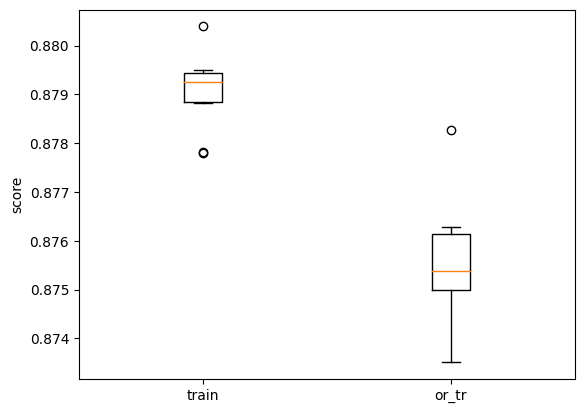

In [7]:
features_for_train = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 
                      'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                      'CI_used_t', 'CI_rate_t']
features_for_or_tr = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
                      'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                      'CI_used_ot', 'CI_rate_ot']
scores = [[],[]]
for i in range(10):
    tra_tr, val_tr = train_test_split(train, test_size=0.3)
    rfc_tr = RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=3, n_estimators=3000, random_state = 0, n_jobs=-1)
    rfc_tr.fit(tra_tr[features_for_train], tra_tr.Exited)
    scores[0].append(rfc_tr.score(val_tr[features_for_train], val_tr.Exited))
for i in range(10):
    tra_ot, val_ot = train_test_split(or_tr, test_size=0.3)
    rfc_ot = RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=3, n_estimators=3000, random_state = 0, n_jobs=-1)
    rfc_ot.fit(tra_ot[features_for_or_tr], tra_ot.Exited)
    scores[1].append(rfc_ot.score(val_ot[features_for_or_tr], val_ot.Exited))

fig, ax = plt.subplots()
ax.boxplot(scores)
ax.set_xticklabels(['train', 'or_tr'])
ax.set_ylabel('score')
plt.show()

## 4. 新しい特徴量の作成
### 4.1. Surnameの現れる回数

In [8]:
# Surnameの現れる回数
sur_used_cat = {}
for s in set(train.Surname.unique()).union(set(test.Surname.unique())):
    sur_used_cat[s] = len(train[train.Surname==s]) + len(test[test.Surname==s])
for data in [train, test]:
    data['Sur_used'] = data.Surname.map(sur_used_cat)

### 4.2. 各Surnameの口座解除率

In [9]:
# 各Surnameの口座解除率
# rate_t = train.Exited.sum()/len(train)
sur_rate_cat = {}
for s in train.Surname.unique():
    sur_rate_cat[s] = (len(train[(train.Surname==s)&(train.Exited==1)])+rate_t)/(len(train[train.Surname==s])+1)
for s in set(test.Surname.unique())-set(train.Surname.unique()):
    sur_rate_cat[s] = rate_t
for data in [train, test]:
    data['Sur_rate'] = data.Surname.map(sur_rate_cat)

### 4.3. 特徴量の検証

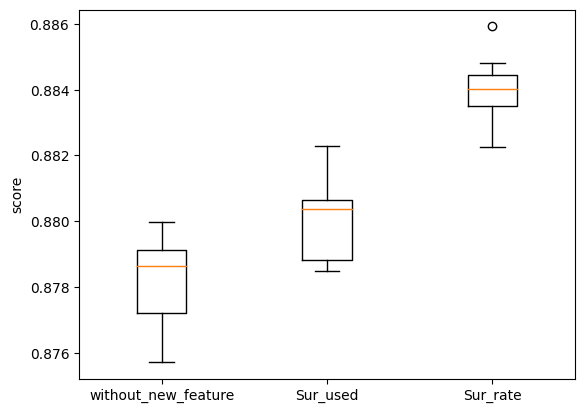

In [10]:
features_for_val = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 
                    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                    'CI_used_t', 'CI_rate_t']
new_features = ['Sur_used', 'Sur_rate']
scores = [[]]
for i in range(10):
    tra, val = train_test_split(train, test_size=0.3)
    rfc = RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=3, n_estimators=3000, random_state = 0, n_jobs=-1)
    rfc.fit(tra[features_for_val], tra.Exited)
    scores[-1].append(rfc.score(val[features_for_val], val.Exited))
for nf in new_features:
    scores.append([])
    for i in range(10):
        tra, val = train_test_split(train, test_size=0.3)
        rfc = RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=3, n_estimators=3000, random_state = 0, n_jobs=-1)
        rfc.fit(tra[features_for_val+[nf]], tra.Exited)
        scores[-1].append(rfc.score(val[features_for_val+[nf]], val.Exited))
fig, ax = plt.subplots()
ax.boxplot(scores)
ax.set_xticklabels(['without_new_feature']+new_features)
ax.set_ylabel('score')
plt.show()